In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Toric Code Ground State

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/toric_code/toric_code_ground_state"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/toric_code/toric_code_ground_state.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/toric_code/toric_code_ground_state.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/toric_code/toric_code_ground_state.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

Before beginning, we will import the necessary modules into the colab.

In [3]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
    import recirq

try:
    import qsimcirq
except ImportError:
    !pip install qsimcirq --quiet
    import qsimcirq

import cirq
import matplotlib.pyplot as plt

import recirq.toric_code.toric_code_plaquettes as tcp
import recirq.toric_code.toric_code_plotter as tcplot
import recirq.toric_code.toric_code_rectangle as tcr
import recirq.toric_code.toric_code_state_prep as tcsp

plt.rcParams['figure.dpi'] = 144

### Toric code Hamiltonian

The toric code Hamiltonian

\begin{equation}
H = -\sum_s A_s - \sum_p B_p
\end{equation}

involves local four-qubit parity operators, where each qubit lives on an edge in a square lattice. Here, the "star" operators $A_s$ are products of Pauli $Z$ operators around a vertex, while the "plaquette" operators $B_p$ are products of $X$ operators around a square, for example,

\begin{equation}
A_s = Z_i \otimes Z_j \otimes Z_k \otimes Z_l 
\end{equation}
\begin{equation}
B_p = X_a \otimes X_b \otimes X_c \otimes X_d.
\end{equation}

These local parity operators all commute with each other: all $A_s$ commute, all $B_p$ commute, and $A_s$ and $B_p$ commute with each other because they overlap on an even number of qubits. They can thus all be simultaneously diagonalized, and those shared eigenstates are also the eigenstates of $H$.


<img src="../images/toric_code1.png" alt="Toric Code Example"/>


In our paper, we mostly work with the 31-qubit lattice above. With these boundary conditions, there is a _unique_ ground state that has a $+1$ eigenvalue for all $A_s$ and $B_p$. Note for different boundary conditions, we can have _degeneracies_ that are locally-indistinguishable (for example on a torus, or with the "surface code" logical qubits we explore in Figure 4 of our paper).

In this module, we will primarily work with the smaller 22-qubit to avoid time and memory constraints associated with the larger rectangle.

### Understanding the ground state

In this example, we focus on reproducing our first figure, where we create this unique ground state $|G\rangle$ using a shallow unitary circuit. The general idea is to start out with $|0\rangle^{\otimes 22}$, so all $\langle A_s \rangle = +1$. We then apply projection operators $\mathbb{I} + B_p$ which project the state into a $+1$ eigenstate of $B_p$, after which all the local parities are $+1$:

\begin{equation}
|G\rangle \propto \prod_p (\mathbb{I} + B_p)|0\rangle^{\otimes 22}.
\end{equation}

To create this state, we assign a "team captain" qubit to each plaquette $B_p$. Starting from $|0\rangle^{\otimes n}$, we perform a Hadamard on each team captain, and then each team captain is responsible for performing a CNOT to each of its team mates. We have to be careful with the ordering to keep things efficient and avoid the captains stepping on each other's toes. This is easier to visualize for a smaller system, for example the 12-qubit version in Figure S2, reproduced below. Note the superposition of $2^4$ states, as there are four plaquettes $B_p$.

<img src="../images/toric_code2.png" alt="12 qubit toric code example"/>

### Creating $|G\rangle$ with ReCirq

#### Basics: 22-qubit circuit

First, we can create a example 22-qubit grid by instantiate it using a `ToricCodeRectangle` object and then plot a visualization using a `ToricCodePlotter` object, both found in the ReCirq repository.

<AxesSubplot:>

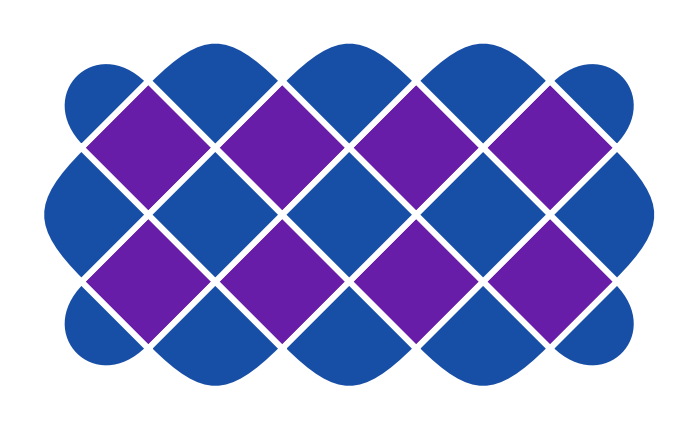

In [4]:
short_rectangle = tcr.ToricCodeRectangle(
    origin_qubit=cirq.GridQubit(3, 0), row_vector=(1, 1), rows=2, cols=4
)
plotter = tcplot.ToricCodePlotter()
plotter.plot_code(short_rectangle)

We can also see the full circuit of how to create this code (using CNOT gates) using these objects as well.  By printing out the circuit moment by moment, we can see the gates lined up in a visual manner.

In [5]:
full_circuit = tcsp.toric_code_cnot_circuit(short_rectangle)
for idx, moment in enumerate(full_circuit):
    print(f'moment {idx}\n{moment}\n')

moment 0
  ╷ 0 1 2 3 4
╶─┼───────────
0 │       H
  │
1 │     H   H
  │
2 │   H   H
  │
3 │ H   H
  │
4 │   H
  │

moment 1
  ╷ 1 2 3
╶─┼───────
1 │   @
  │   │
2 │ @ X @
  │ │   │
3 │ X @ X
  │   │
4 │   X
  │

moment 2
  ╷ 1 2 3 4
╶─┼─────────
1 │   @─X
  │
2 │ @─X @─X
  │
3 │   @─X
  │

moment 3
  ╷ 0 1 2 3 4 5
╶─┼─────────────
0 │       @─X
  │
1 │       @ @─X
  │       │
2 │       X @
  │         │
3 │ @ @─X   X
  │ │
4 │ X @ @─X
  │   │
5 │   X
  │

moment 4
  ╷ 0 1 2 3 4
╶─┼───────────
0 │       @
  │       │
1 │       X @
  │         │
2 │         X
  │
3 │ @─X
  │
4 │   @─X
  │

moment 5
  ╷ 0 1 2 4 5
╶─┼───────────
0 │       @
  │       │
1 │       X @
  │         │
2 │         X
  │
4 │ @─X
  │
5 │   @─X
  │



#### Simulating the parities

For a given circuit, we can determine all the parity expectation values $\langle A_s\rangle$ by sampling 22-qubit bitstrings and then computing each expectation value. We do the same thing with for $\langle B_p \rangle$, but we include a layer of Hadamards before measurement to effectively "measure in $X$ basis."

In [6]:
def partial_circuit(
    n_moments_to_include: int, *, x_basis: bool
) -> cirq.Circuit:
    """Create the first N moments of a toric in Z or X basis.
 
    Args:
        n_moments_to_include: number of moments to include
        x_basis: If True, add Hadamards to effectively measure in the X basis.
            If False, measure in the computational (Z) basis.

    Returns: First N moments of a toric code circuit plus an optional
        layer of Hadamard gates to effectively measure in the X basis.
        This circuit also includes measurement gates.
    """
    sliced_circuit = full_circuit[:n_moments_to_include]
    qubits = sorted(short_rectangle.qubits)
    if x_basis:
        sliced_circuit += cirq.Moment(cirq.H.on_each(*qubits))
    return sliced_circuit + cirq.measure(*qubits)


def get_plaquettes(
    n_moment_to_include: int, repetitions: int = 1000,
    sampler: cirq.Sampler = qsimcirq.QSimSimulator()
) -> tcp.ToricCodePlaquettes:
    """Simulates the results in both bases and determine plaquette values.

    Args:
            n_moments_to_include: number of moments to include
            repetitions: number of repetitions (shots) to sample
            sampler: Sampler (simulator) to execute circuits.  Defaults to qsim.
    """
    x_data = sampler.run(
        partial_circuit(n_moment_to_include, x_basis=True), repetitions=repetitions
    )
    z_data = sampler.run(
        partial_circuit(n_moment_to_include, x_basis=False), repetitions=repetitions
    )
    return tcp.ToricCodePlaquettes.from_global_measurements(
        short_rectangle, x_data.data, z_data.data
    )

We can step through the circuit one moment at a time to see how the parities $A_s$ and $B_p$ evolve through the circuit. This is similar to Figure 1B in paper (but simulating instead of using experimental data). We begin with $|0\rangle^{\otimes 22}$, which corresponds to `n_moments_to_include=0`. There, all $\langle A_s \rangle = +1$ but $\langle B_p \rangle = 0$ (see colorbars below). The subsequent moments apply Hadamard and CNOT gates to stitch entanglement across the device and create $|G\rangle$.

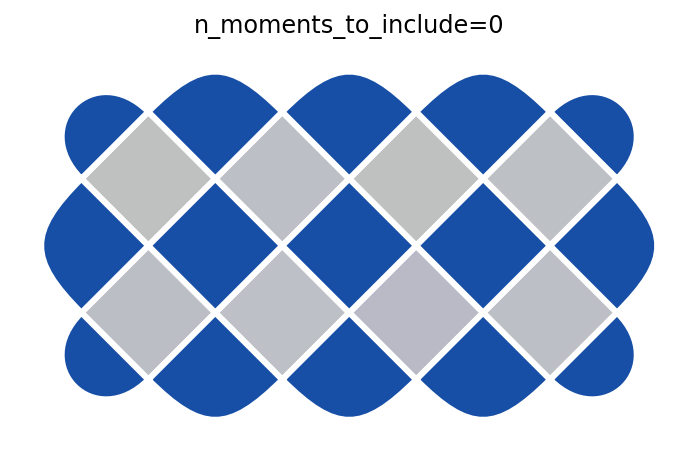

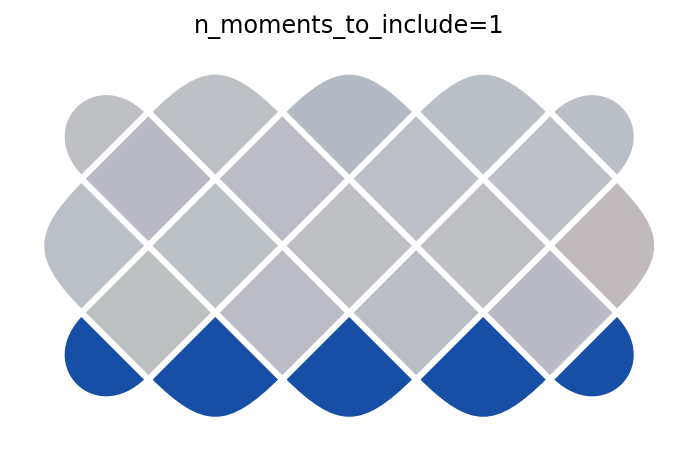

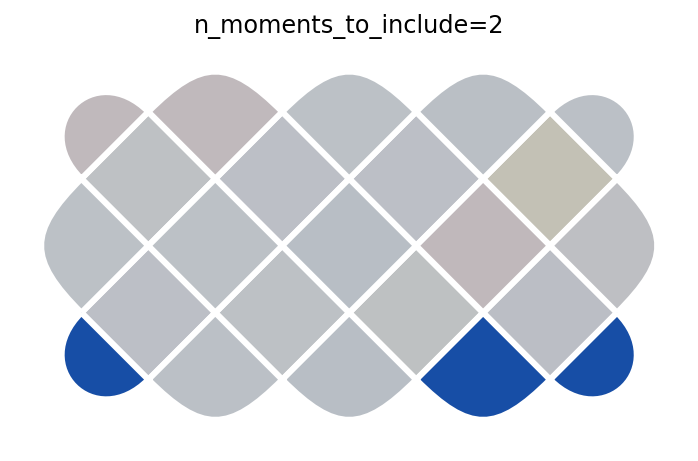

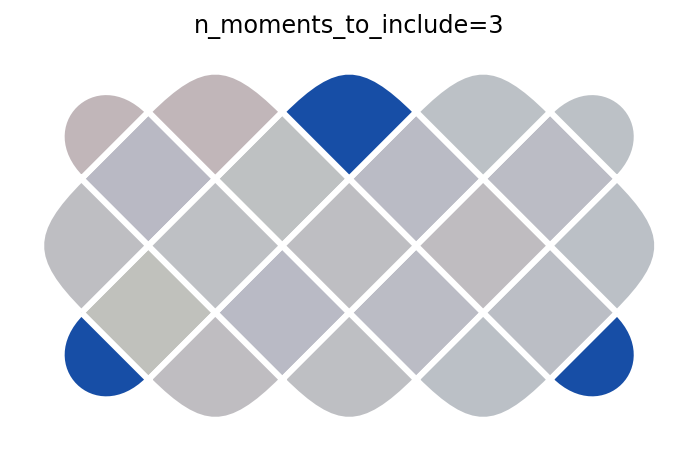

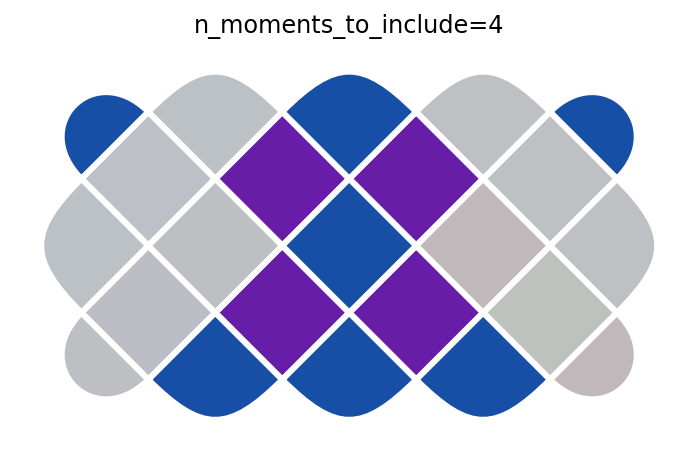

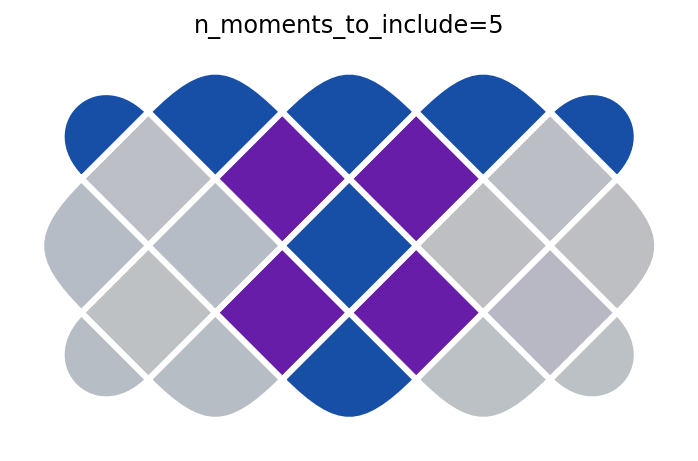

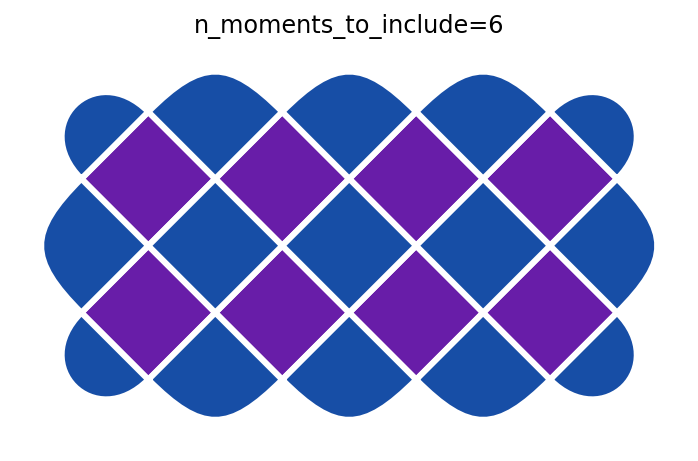

In [7]:
for n in range(len(tcsp.toric_code_cnot_circuit(short_rectangle)) + 1):
    p = get_plaquettes(n)
    ax = plotter.plot_expectation_values(p)
    ax.set_title(f'n_moments_to_include={n}')
    plt.pause(0.001)

After the final step, all the parities are $+1$ (see colorbars below), indicating we have successfully created $|G\rangle$.

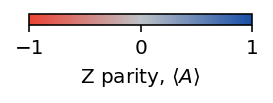

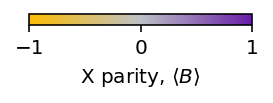

In [8]:
ax_z = plotter.make_colorbar(x_basis=False, orientation='horizontal')
ax_z.set_label(r'Z parity, $\langle A\rangle$')

ax_x = plotter.make_colorbar(x_basis=True, orientation='horizontal')
ax_x.set_label(r'X parity, $\langle B\rangle$')